In [1]:
import os
from collections import Counter
import random
import math
import logging
import pickle
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from torch.amp import GradScaler, autocast

# Настройка логирования
logging.basicConfig(
    filename='training.log',
    level=logging.INFO,
    format='%(asctime)s - %(message)s'
)

# Гиперпараметры
BATCH_SIZE = 64
NUM_EPOCHS = 60
INITIAL_LR = 0.002
PATIENCE = 3  # Для ранней остановки
NUM_WORKERS = 4  
NUM_CLASSES = None  # Будет определено позже
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Пути к данным и моделям
ROOT_DATA_DIR = '/mnt/d/Python/Project/Nikitenko_multi_class/DataSet_V3/'
CHECKPOINT_PATH = '/mnt/d/Python/Project/Nikitenko_multi_class/models/v5/checkpoint.pth'
LOSSES_PATH = '/mnt/d/Python/Project/Nikitenko_multi_class/models/v5/losses.pkl'

# Трансформации
common_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
])

train_transform = transforms.Compose([
    common_transform,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation((-15, 15)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

# Загрузка данных
class_names = sorted(os.listdir(ROOT_DATA_DIR))
NUM_CLASSES = len(class_names)
all_data = datasets.ImageFolder(root=ROOT_DATA_DIR)

# Стратифицированное разбиение на train/val/test
train_indices, temp_indices = train_test_split(
    range(len(all_data)),
    test_size=0.3,
    stratify=all_data.targets,
    random_state=41
)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    stratify=[all_data.targets[i] for i in temp_indices],
    random_state=41
)

# Создание датасетов
train_dataset = Subset(all_data, train_indices)
val_dataset = Subset(all_data, val_indices)
test_dataset = Subset(all_data, test_indices)

# Установка трансформаций
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = common_transform
test_dataset.dataset.transform = common_transform

# WeightedRandomSampler для борьбы с дисбалансом
cls_counts = Counter([all_data.targets[i] for i in train_indices])
weights = [1.0 / cls_counts[all_data.targets[i]] for i in train_indices]
sampler = WeightedRandomSampler(weights, len(weights))

# Загрузчики данных
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

# Проверка распределения классов
def print_class_distribution(dataset, indices, class_names, name="Dataset"):
    if isinstance(dataset, Subset):
        targets = [dataset.dataset.targets[i] for i in indices]
    else:
        targets = [dataset.targets[i] for i in indices]
    
    counts = Counter(targets)
    print(f"\nРаспределение классов в {name}:")
    for class_idx, count in sorted(counts.items()):
        print(f"{class_idx}. {class_names[class_idx]}: {count}")

print(f"Количество классов: {NUM_CLASSES}")
print(f"Обучающих данных: {len(train_dataset)}")
print(f"Валидационных данных: {len(val_dataset)}")
print(f"Тестовых данных: {len(test_dataset)}")
print_class_distribution(all_data, train_indices, class_names, "train")
print_class_distribution(all_data, val_indices, class_names, "val")
print_class_distribution(all_data, test_indices, class_names, "test")

# Расчёт весов классов для CrossEntropyLoss
cls_counts = Counter([all_data.targets[i] for i in train_indices])
cls_num_list = [cls_counts[i] for i in range(NUM_CLASSES)]
cls_num_tensor = torch.tensor(cls_num_list, dtype=torch.float32)
weight = torch.sum(cls_num_tensor) / (NUM_CLASSES * cls_num_tensor)
weight = weight / weight.sum() * NUM_CLASSES

# Модуль канального внимания
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_planes // ratio, in_planes, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).squeeze(-1).squeeze(-1))
        max_out = self.fc(self.max_pool(x).squeeze(-1).squeeze(-1))
        out = avg_out + max_out
        return self.sigmoid(out).unsqueeze(-1).unsqueeze(-1)

# Модуль пространственного внимания
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.norm = nn.BatchNorm2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        x = self.norm(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        return self.sigmoid(x)

# CBAM (Convolutional Block Attention Module)
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Модель с CBAM
class MyNetWithCBAM(nn.Module):
    def __init__(self, in_channels: int = 3, num_of_classes: int = NUM_CLASSES):
        super(MyNetWithCBAM, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b1')
        in_features_efficient_net = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Identity()
        self.cbam = CBAM(in_planes=self.efficient_net._conv_head.out_channels)
        self.base_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features_efficient_net, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_of_classes)
        )

    def forward(self, x):
        x_efficient_net = self.efficient_net.extract_features(x)
        x_efficient_net = self.cbam(x_efficient_net)
        x_efficient_net = x_efficient_net.mean([2, 3])
        x_base_model = self.base_classifier(x_efficient_net)
        x = self.classifier(x_base_model)
        return x

# Функция потерь с Label Smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

criterion = LabelSmoothingCrossEntropy(smoothing=0.1).to(DEVICE)

# Инициализация модели и оптимизатора
model = MyNetWithCBAM(num_of_classes=NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
scaler = torch.amp.GradScaler('cuda')

# Шедулер ReduceLROnPlateau с threshold вместо min_delta
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.01, threshold_mode='abs'
)

# Универсальная функция визуализации
def visualize_images(model, dataset, class_names, device, mode='random', num_images=10, num_cols=5):
    model.eval()
    images, true_labels, pred_labels = [], [], []

    if mode == 'random':
        indices = random.sample(range(len(dataset)), num_images)
        with torch.no_grad():
            for idx in indices:
                img, true_label = dataset[idx]
                img = img.unsqueeze(0).to(device)
                output = model(img)
                _, pred_label = torch.max(output, 1)
                images.append(img.cpu())
                true_labels.append(true_label)
                pred_labels.append(pred_label.item())

    elif mode == 'misclassified':
        with torch.no_grad():
            for i in range(len(dataset)):
                img, true_label = dataset[i]
                img = img.unsqueeze(0).to(device)
                output = model(img)
                _, pred_label = torch.max(output, 1)
                if pred_label.item() != true_label:
                    images.append(img.cpu())
                    true_labels.append(true_label)
                    pred_labels.append(pred_label.item())
                if len(images) >= num_images:
                    break

    if not images:
        print("Нет изображений для отображения.")
        return

    num_rows = (len(images) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            img = images[i].squeeze().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            ax.imshow(img)
            true_label = class_names[true_labels[i]]
            pred_label = class_names[pred_labels[i]]
            title_color = 'red' if true_labels[i] != pred_labels[i] else 'black'
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8, color=title_color)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Функция обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler, num_epochs=NUM_EPOCHS, patience=7, min_delta=0.001):
    model.to(DEVICE)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')

        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            with autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / (batch_idx + 1), accuracy=correct_train / total_train)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Валидация
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                with autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        lr_scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Логирование
        logging.info(
            f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}'
        )
        print(
            f'Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, '
            f'Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}'
        )

        # Сохранение лучшей модели по val_acc с учетом min_delta
        if val_acc > best_val_acc + min_delta:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Ранняя остановка
        if patience_counter >= patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

# Функция оценки модели
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_true_labels, all_predicted_labels = [], []
    total_test = 0
    incorrect_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted_labels = torch.max(outputs, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            total_test += labels.size(0)
            incorrect_test += (predicted_labels != labels).sum().item()

    # Вывод количества ошибок и общего числа тестовых примеров
    print(f"Общее количество тестовых примеров: {total_test}")
    print(f"Количество ошибочных предсказаний: {incorrect_test}")
    print(f"Доля ошибочных предсказаний: {incorrect_test / total_test:.4f}")

    # Матрица ошибок
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report и F1-score
    report = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')
    print(report)
    print(f"Weighted F1-score: {f1:.4f}")

# Функция сохранения модели
def save_checkpoint_and_losses(
    model, optimizer, num_epochs, train_losses, train_accuracies,
    val_losses, val_accuracies, checkpoint_path, losses_path
):
    try:
        checkpoint = {
            'num_epochs': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
        }
        torch.save(checkpoint, checkpoint_path)

        losses_dict = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
        }
        with open(losses_path, 'wb') as f:
            pickle.dump(losses_dict, f)

        print(f"Модель успешно сохранена в {checkpoint_path}")
    except Exception as e:
        print(f"Ошибка при сохранении модели: {e}")

# Функция загрузки модели
def load_checkpoint_and_losses(model, optimizer, checkpoint_path, losses_path, map_location=None):
    try:
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        num_epochs = checkpoint['num_epochs']
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        val_losses = checkpoint['val_losses']
        val_accuracies = checkpoint['val_accuracies']

        with open(losses_path, 'rb') as f:
            losses_dict = pickle.load(f)
            train_losses_file = losses_dict['train_losses']
            train_accuracies_file = losses_dict['train_accuracies']
            val_losses_file = losses_dict['val_losses']
            val_accuracies_file = losses_dict['val_accuracies']

        print(f"Модель успешно загружена из {checkpoint_path}")
        return (
            model, optimizer, num_epochs, train_losses, train_accuracies,
            val_losses, val_accuracies
        )
    except Exception as e:
        print(f"Ошибка при загрузке модели: {e}")
        return None

# Функция построения графиков метрик
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



Количество классов: 21
Обучающих данных: 6493
Валидационных данных: 1391
Тестовых данных: 1392

Распределение классов в train:
0. Вскрышной  грунт: 769
1. Глина кирпичная: 126
2. Грунт гранитный скальный ГЛЫБОВЫЙ фр.0-500: 67
3. Грунт гранитный скальный глыбовый: 1133
4. Грунт гранитный скальный гравийный фр.0-300: 25
5. Дизельное  топливо: 13
6. Калиброванный-ДРОБЛЕННЫЙ скальный грунт фр.0-200: 26
7. Отсев(фракция 0-3): 10
8. Отсев(фракция 0-5): 170
9. ПустойКузов: 937
10. Супесь: 299
11. ЩПС фракция 0-10: 868
12. ЩПС фракция 0-120: 17
13. ЩПС фракция 0-20: 306
14. ЩПС фракция 0-40: 175
15. ЩПС фракция 0-80: 300
16. Щебень фракция 03-10: 24
17. Щебень фракция 20-40: 664
18. Щебень фракция 40-70: 332
19. Щебень фракция 5-20: 216
20. Щебень фракция 70-120: 16

Распределение классов в val:
0. Вскрышной  грунт: 165
1. Глина кирпичная: 27
2. Грунт гранитный скальный ГЛЫБОВЫЙ фр.0-500: 14
3. Грунт гранитный скальный глыбовый: 243
4. Грунт гранитный скальный гравийный фр.0-300: 6
5. Дизельно

In [2]:
# Запуск обучения
print(f"Запуск обучения с {NUM_CLASSES} классами...")
logging.info(f"Запуск обучения с {NUM_CLASSES} классами...")

# Обучение модели
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, lr_scheduler
)



Запуск обучения с 21 классами...


Epoch 1/60: 100%|██████████████████████████████| 102/102 [01:05<00:00,  1.56it/s, accuracy=0.633, loss=1.55]


Epoch 1/60, Train Acc: 0.6328, Val Acc: 0.6564, Val Loss: 1.7064, LR: 0.002000


Epoch 2/60: 100%|█████████████████████████████████| 102/102 [01:05<00:00,  1.55it/s, accuracy=0.864, loss=1]


Epoch 2/60, Train Acc: 0.8645, Val Acc: 0.7930, Val Loss: 1.1011, LR: 0.002000


Epoch 3/60: 100%|█████████████████████████████| 102/102 [01:04<00:00,  1.59it/s, accuracy=0.902, loss=0.908]


Epoch 3/60, Train Acc: 0.9020, Val Acc: 0.7448, Val Loss: 1.3307, LR: 0.002000


Epoch 4/60: 100%|█████████████████████████████| 102/102 [01:03<00:00,  1.61it/s, accuracy=0.917, loss=0.861]


Epoch 4/60, Train Acc: 0.9173, Val Acc: 0.7498, Val Loss: 1.2596, LR: 0.002000


Epoch 5/60: 100%|█████████████████████████████| 102/102 [01:04<00:00,  1.58it/s, accuracy=0.934, loss=0.817]


Epoch 5/60, Train Acc: 0.9341, Val Acc: 0.7505, Val Loss: 1.3886, LR: 0.001000


Epoch 6/60: 100%|█████████████████████████████| 102/102 [01:06<00:00,  1.53it/s, accuracy=0.968, loss=0.736]


Epoch 6/60, Train Acc: 0.9683, Val Acc: 0.9080, Val Loss: 0.8439, LR: 0.001000


Epoch 7/60: 100%|█████████████████████████████| 102/102 [01:09<00:00,  1.47it/s, accuracy=0.978, loss=0.699]


Epoch 7/60, Train Acc: 0.9777, Val Acc: 0.9339, Val Loss: 0.7873, LR: 0.001000


Epoch 8/60: 100%|█████████████████████████████| 102/102 [01:07<00:00,  1.51it/s, accuracy=0.984, loss=0.686]


Epoch 8/60, Train Acc: 0.9840, Val Acc: 0.9216, Val Loss: 0.8159, LR: 0.001000


Epoch 9/60: 100%|█████████████████████████████| 102/102 [01:06<00:00,  1.53it/s, accuracy=0.987, loss=0.678]


Epoch 9/60, Train Acc: 0.9869, Val Acc: 0.9295, Val Loss: 0.7965, LR: 0.001000


Epoch 10/60: 100%|████████████████████████████| 102/102 [01:05<00:00,  1.55it/s, accuracy=0.984, loss=0.683]


Epoch 10/60, Train Acc: 0.9840, Val Acc: 0.9324, Val Loss: 0.7899, LR: 0.000500


Epoch 11/60: 100%|█████████████████████████████| 102/102 [01:04<00:00,  1.57it/s, accuracy=0.992, loss=0.66]


Epoch 11/60, Train Acc: 0.9915, Val Acc: 0.9367, Val Loss: 0.7648, LR: 0.000500


Epoch 12/60: 100%|████████████████████████████| 102/102 [01:05<00:00,  1.55it/s, accuracy=0.995, loss=0.652]


Epoch 12/60, Train Acc: 0.9951, Val Acc: 0.9446, Val Loss: 0.7552, LR: 0.000500


Epoch 13/60: 100%|████████████████████████████| 102/102 [01:04<00:00,  1.58it/s, accuracy=0.995, loss=0.648]


Epoch 13/60, Train Acc: 0.9954, Val Acc: 0.9482, Val Loss: 0.7646, LR: 0.000500


Epoch 14/60: 100%|████████████████████████████| 102/102 [01:04<00:00,  1.58it/s, accuracy=0.997, loss=0.644]


Epoch 14/60, Train Acc: 0.9972, Val Acc: 0.9518, Val Loss: 0.7640, LR: 0.000250


Epoch 15/60: 100%|████████████████████████████| 102/102 [01:02<00:00,  1.62it/s, accuracy=0.998, loss=0.639]


Epoch 15/60, Train Acc: 0.9983, Val Acc: 0.9554, Val Loss: 0.7510, LR: 0.000250


Epoch 16/60: 100%|████████████████████████████| 102/102 [01:04<00:00,  1.59it/s, accuracy=0.998, loss=0.639]


Epoch 16/60, Train Acc: 0.9980, Val Acc: 0.9554, Val Loss: 0.7454, LR: 0.000250


Epoch 17/60: 100%|████████████████████████████| 102/102 [01:04<00:00,  1.59it/s, accuracy=0.999, loss=0.636]


Epoch 17/60, Train Acc: 0.9989, Val Acc: 0.9526, Val Loss: 0.7401, LR: 0.000250


Epoch 18/60: 100%|████████████████████████████| 102/102 [01:03<00:00,  1.60it/s, accuracy=0.998, loss=0.637]


Epoch 18/60, Train Acc: 0.9978, Val Acc: 0.9569, Val Loss: 0.7336, LR: 0.000250


Epoch 19/60: 100%|████████████████████████████| 102/102 [01:02<00:00,  1.64it/s, accuracy=0.999, loss=0.635]


Epoch 19/60, Train Acc: 0.9988, Val Acc: 0.9561, Val Loss: 0.7368, LR: 0.000250


Epoch 20/60: 100%|████████████████████████████| 102/102 [01:04<00:00,  1.58it/s, accuracy=0.999, loss=0.634]


Epoch 20/60, Train Acc: 0.9988, Val Acc: 0.9569, Val Loss: 0.7310, LR: 0.000125


Epoch 21/60: 100%|████████████████████████████| 102/102 [01:03<00:00,  1.61it/s, accuracy=0.999, loss=0.631]


Epoch 21/60, Train Acc: 0.9994, Val Acc: 0.9576, Val Loss: 0.7347, LR: 0.000125


Epoch 22/60: 100%|████████████████████████████| 102/102 [01:06<00:00,  1.53it/s, accuracy=0.998, loss=0.634]


Epoch 22/60, Train Acc: 0.9982, Val Acc: 0.9576, Val Loss: 0.7344, LR: 0.000125


Epoch 23/60: 100%|████████████████████████████| 102/102 [01:02<00:00,  1.64it/s, accuracy=0.999, loss=0.631]


Epoch 23/60, Train Acc: 0.9991, Val Acc: 0.9554, Val Loss: 0.7368, LR: 0.000063


Epoch 24/60: 100%|████████████████████████████| 102/102 [01:03<00:00,  1.60it/s, accuracy=0.999, loss=0.631]


Epoch 24/60, Train Acc: 0.9992, Val Acc: 0.9569, Val Loss: 0.7357, LR: 0.000063


Epoch 25/60: 100%|█████████████████████████████| 102/102 [01:04<00:00,  1.58it/s, accuracy=0.999, loss=0.63]


Epoch 25/60, Train Acc: 0.9992, Val Acc: 0.9561, Val Loss: 0.7358, LR: 0.000063
Ранняя остановка на эпохе 25


In [5]:
class_names

['Вскрышной  грунт',
 'Глина кирпичная',
 'Грунт гранитный скальный ГЛЫБОВЫЙ фр.0-500',
 'Грунт гранитный скальный глыбовый',
 'Грунт гранитный скальный гравийный фр.0-300',
 'Дизельное  топливо',
 'Калиброванный-ДРОБЛЕННЫЙ скальный грунт фр.0-200',
 'Отсев(фракция 0-3)',
 'Отсев(фракция 0-5)',
 'ПустойКузов',
 'Супесь',
 'ЩПС фракция 0-10',
 'ЩПС фракция 0-120',
 'ЩПС фракция 0-20',
 'ЩПС фракция 0-40',
 'ЩПС фракция 0-80',
 'Щебень фракция 03-10',
 'Щебень фракция 20-40',
 'Щебень фракция 40-70',
 'Щебень фракция 5-20',
 'Щебень фракция 70-120']

Модель успешно сохранена в /mnt/d/Python/Project/Nikitenko_multi_class/models/v5/checkpoint.pth


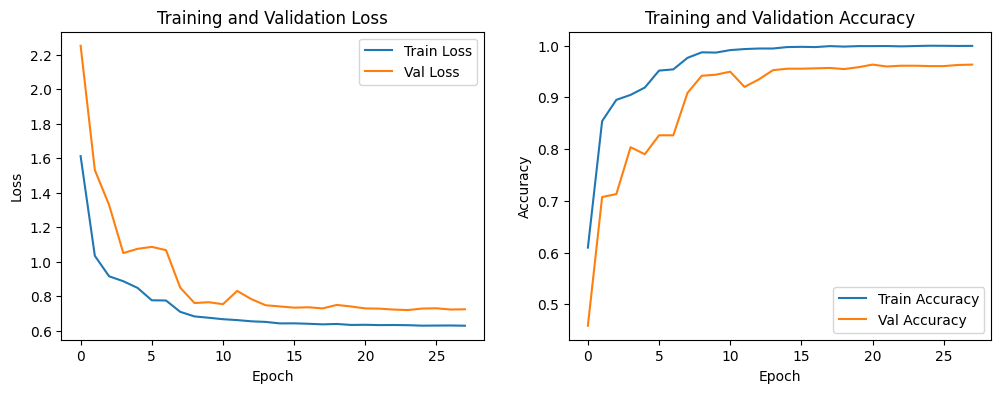

Общее количество тестовых примеров: 1392
Количество ошибочных предсказаний: 61
Доля ошибочных предсказаний: 0.0438


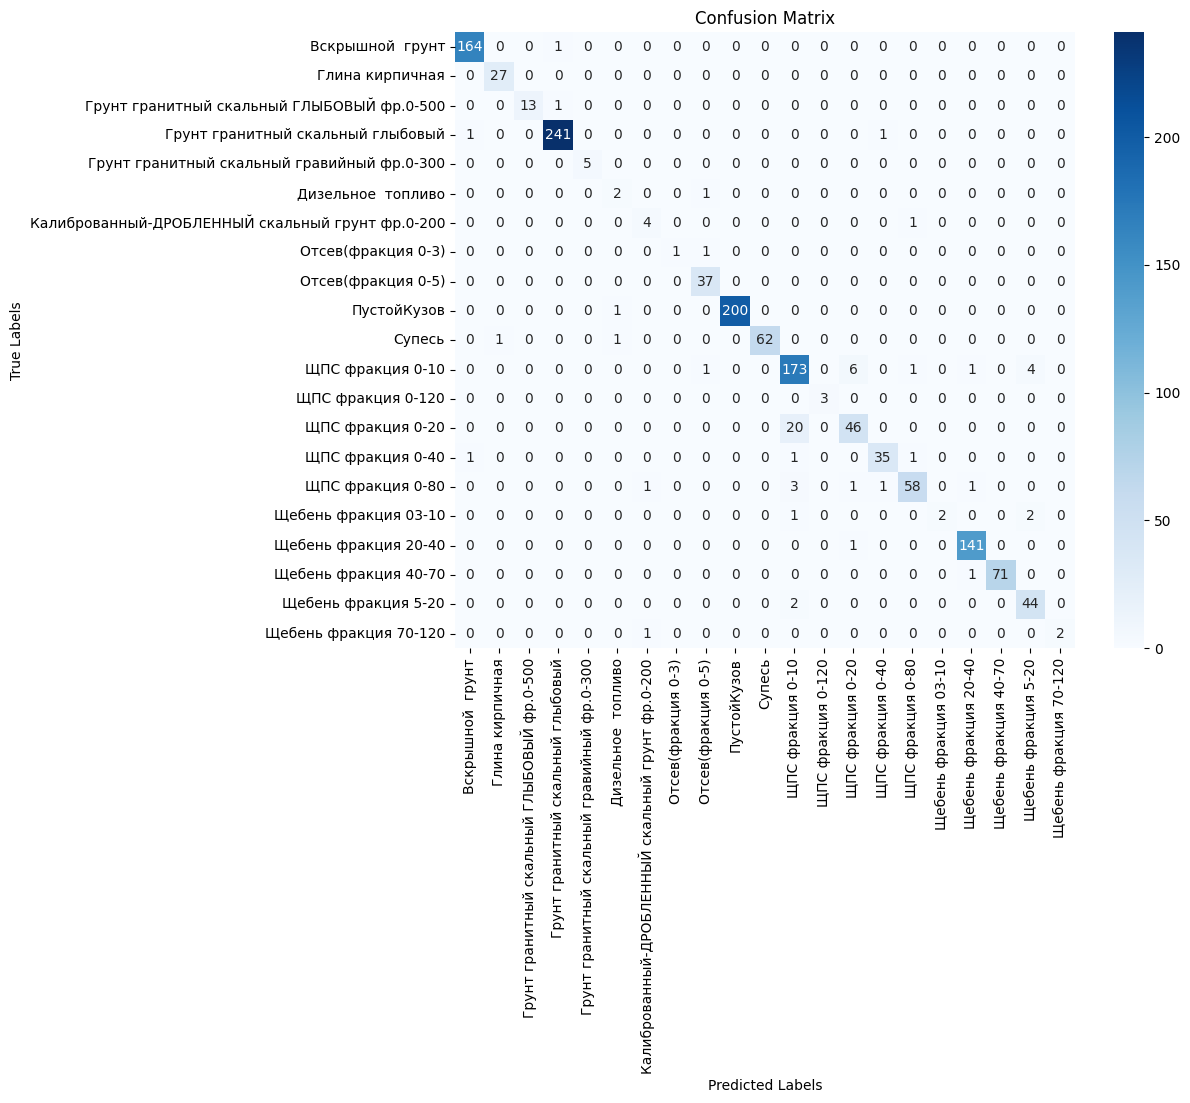

                                                  precision    recall  f1-score   support

                                Вскрышной  грунт       0.99      0.99      0.99       165
                                 Глина кирпичная       0.96      1.00      0.98        27
      Грунт гранитный скальный ГЛЫБОВЫЙ фр.0-500       1.00      0.93      0.96        14
               Грунт гранитный скальный глыбовый       0.99      0.99      0.99       243
     Грунт гранитный скальный гравийный фр.0-300       1.00      1.00      1.00         5
                              Дизельное  топливо       0.50      0.67      0.57         3
Калиброванный-ДРОБЛЕННЫЙ скальный грунт фр.0-200       0.67      0.80      0.73         5
                              Отсев(фракция 0-3)       1.00      0.50      0.67         2
                              Отсев(фракция 0-5)       0.93      1.00      0.96        37
                                     ПустойКузов       1.00      1.00      1.00       201
         

In [3]:
# Сохранение модели и метрик
save_checkpoint_and_losses(
    model, optimizer, NUM_EPOCHS, train_losses, train_accuracies,
    val_losses, val_accuracies, CHECKPOINT_PATH, LOSSES_PATH
)

# Построение графиков
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Оценка на тестовой выборке
evaluate_model(model, test_loader, class_names)

In [3]:
# Универсальная функция визуализации
def visualize_images(model, dataset, class_names, device, mode='random', num_images=10, num_cols=5):
    model.eval()
    images, true_labels, pred_labels = [], [], []

    if mode == 'random':
        indices = random.sample(range(len(dataset)), num_images)
        with torch.no_grad():
            for idx in indices:
                img, true_label = dataset[idx]
                img = img.unsqueeze(0).to(device)
                output = model(img)
                _, pred_label = torch.max(output, 1)
                images.append(img.cpu())
                true_labels.append(true_label)
                pred_labels.append(pred_label.item())

    elif mode == 'misclassified':
        with torch.no_grad():
            for i in range(len(dataset)):
                img, true_label = dataset[i]
                img = img.unsqueeze(0).to(device)
                output = model(img)
                _, pred_label = torch.max(output, 1)
                if pred_label.item() != true_label:
                    images.append(img.cpu())
                    true_labels.append(true_label)
                    pred_labels.append(pred_label.item())
                if len(images) >= num_images:
                    break

    if not images:
        print("Нет изображений для отображения.")
        return

    num_rows = (len(images) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            img = images[i].squeeze().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())  # Нормализация
            ax.imshow(img)
            true_label = class_names[true_labels[i]]
            pred_label = class_names[pred_labels[i]]
            title_color = 'red' if true_labels[i] != pred_labels[i] else 'black'
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8, color=title_color)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

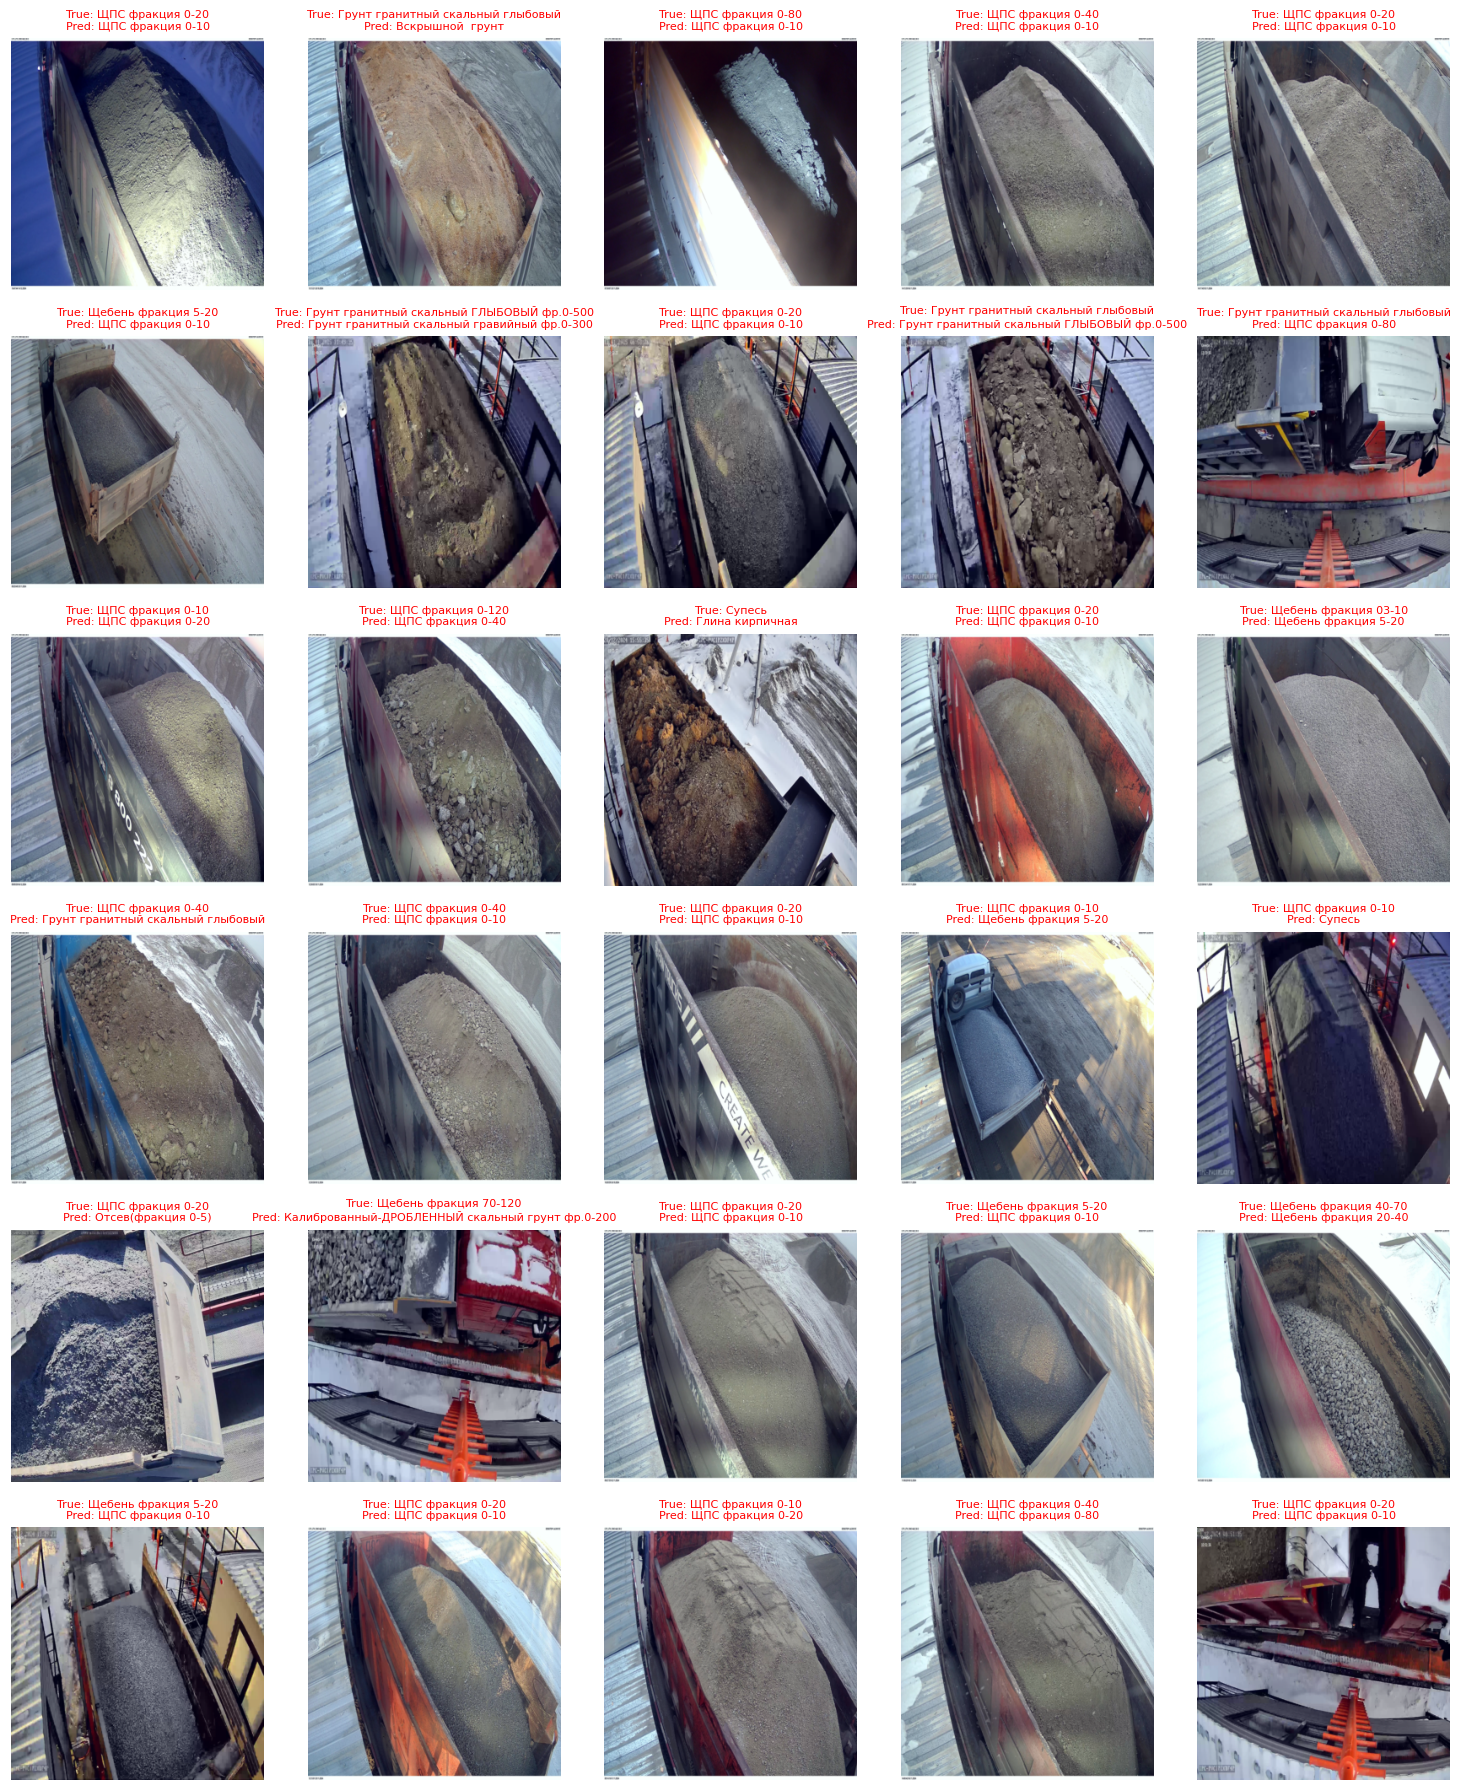

In [4]:
# Визуализация ошибочных предсказаний
visualize_images(model, test_dataset, class_names, DEVICE, mode='misclassified', num_images=30)